In [1]:
import cv2
import numpy as np
from PIL import Image

In [2]:
cap = cv2.VideoCapture('../videoData/five_people.mp4')

net = cv2.dnn.readNet('./yolov4_training_last.weights','./yolov4_training.cfg')
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print(fps,size)

classes = []
#讀取類別名稱txt
with open('./classes.txt','r')as f:
    classes = f.read().splitlines()
print(classes)


counter = 0
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
     #讀取要辨識的圖片
    if counter % 30 == 0:
        img=frame
        #讀取畫面長、寬、通道
        height, width, channel =size[0],size[1],3
        #將影像預處理，參數依序為：影像、正規化、縮放尺寸、RB通道交換
        blob = cv2.dnn.blobFromImage(img, 1/255, (608,608), swapRB=True)
        #將影像輸入神經網路
        net.setInput(blob)
        #列出YOLO神經網路輸出層的名稱，YOLOv4有3個輸出層
        output_layers_names = net.getUnconnectedOutLayersNames()
        #將這幾層的輸出結果儲存，為多個5+classes維的數組
        #5+classes維是由預測框的中心點參數x,y、預測框的長寬參數w,h、
        #存在物件的信心度和所屬各類別的信心度所組成
        layerOutputs = net.forward(output_layers_names)
        
        boxes = [] #暫存預測框的參數用
        confidences = [] #暫存存在物件信心度用
        class_ids = [] #暫存分類編號用
        #篩選預測框及分類閥值，輸出層有三個，外迴圈跑三次
        #內迴圈次數依據預測框的數量
        for output in layerOutputs:
            for detection in output:
                #找尋信心度最高的分類
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                #篩選閥值及儲存框參數
                if confidence > 0.5:
                    #預測框參數的範圍皆為0~1
                    #需做比例尺轉換
                    center_x = int(detection[0]*width)
                    center_y = int(detection[1]*height)
                    w = int(detection[2]*width)
                    h = int(detection[3]*height)
                    x = int(center_x - w/2)
                    y = int(center_y - h/2)
                    #暫存預測框參數
                    boxes.append([x,y,w,h])
                    #暫存信心度
                    confidences.append((float(confidence)))
                    #暫存分類編號
                    class_ids.append(class_id)
        #第二次篩選預測框，參數依序為：預測框參數、存在物件信心度、
        #信心度閥值及IoU閥值，
        indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.6,0.5)
            
        #畫面標示文字的字體設定，此為小號無襯線字體
        font = cv2.FONT_HERSHEY_PLAIN
        #暫存預測框顏色用
        colors = []
        #賦予每個預測框顏色
        for i in range(len(boxes)):
            colors=np.append(colors,[0,0,255])
        colors=np.reshape(colors, (len(boxes),3))
        
        #將預測框放在影像上
        num_no_mask = 0
        num_with_mask = 0
        if len(indexes)>0:
            for i in indexes.flatten():
                x,y,w,h = boxes[i]
                #將分類編號對應類別名稱
                label = str(classes[class_ids[i]])
                # print(label)
                #取信心度小數點後兩位
                confidence = str(round(confidences[i],2))
                #預測框顏色
                if label == 'person_with_mask':
                    color=(0,255,0) #Green 
                    num_with_mask+=1
                else:
                    color=(0,0,255)
                    num_no_mask+=1
                #放置預測框    
                cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
                #若要在預測框上顯示類別名稱與信心度可取消下方註解
                # cv2.putText(img, label,(x,y-5),font,1,color,1)
                # cv2.putText(img, label + " " + confidence ,(x,y+5),font,1,color,1)
        
        #左上角顯示預測框數量，參數依序為：影像、位置、字體、縮放比、顏色、粗細
        cv2.putText(img, "No_mask: "+str(num_no_mask),(200,50),font,2,(0,0,255),2)
        cv2.putText(img, "Total:"+str(len(indexes)),(50,50),font,2,(255,50,0),2)
        # cv2.putText(img,str(num_no_mask)+","+str())
        #儲存完成辨識後的圖片
        cv2.imshow('frame', img)
    if cv2.waitKey(1) == ord('q'):
        break
    counter += 1
cap.release()
cv2.destroyAllWindows()

17.16863007041867 (600, 800)
['person_no_mask', 'person_with_mask']
Can't receive frame (stream end?). Exiting ...


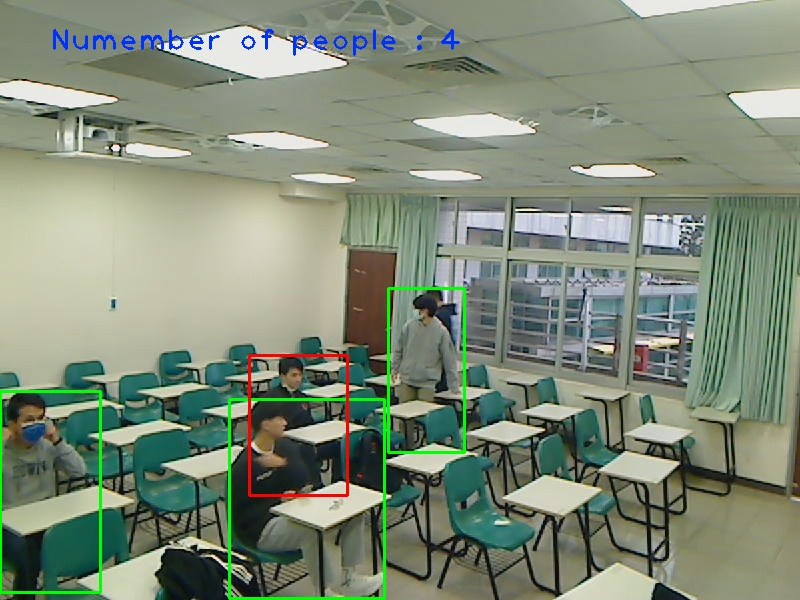

In [6]:
from PIL import Image
Image.open('./test.jpg')